In [1]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
from tqdm import tqdm

In [2]:
# Define dataset directories
base_dir = "marine-animals-dataset_1/versions/1"  # Replace with your dataset path
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

In [3]:
# Image preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    horizontal_flip=True,
    rotation_range=10,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2
)
valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1241 images belonging to 5 classes.
Found 250 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


In [4]:
# Print class indices
class_indices = train_generator.class_indices
print("Class indices:", class_indices)

# Load VGG16 model without top layers for feature extraction
vgg16_base = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
model = Model(inputs=vgg16_base.input, outputs=vgg16_base.get_layer("block5_pool").output)

Class indices: {'Dolphin': 0, 'Fish': 1, 'Lobster': 2, 'Octopus': 3, 'Sea Horse': 4}


In [5]:

# Feature extraction with Global Average Pooling (GAP)
def extract_features_with_gap(generator, model):
    features = []
    labels = []
    for inputs_batch, labels_batch in tqdm(generator, desc="Extracting Features"):
        batch_features = model.predict(inputs_batch)
        batch_features = np.mean(batch_features, axis=(1, 2))  # Global Average Pooling
        features.append(batch_features)
        labels.append(labels_batch)
        if len(features) >= len(generator):  # Stop after one epoch
            break
    return np.vstack(features), np.vstack(labels)

In [6]:
# Extract features for training and validation datasets
train_features, train_labels = extract_features_with_gap(train_generator, model)
valid_features, valid_labels = extract_features_with_gap(valid_generator, model)


Extracting Features:   0%|          | 0/39 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


Extracting Features:   3%|▎         | 1/39 [00:07<04:47,  7.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Extracting Features:   5%|▌         | 2/39 [00:13<04:07,  6.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Extracting Features:   8%|▊         | 3/39 [00:19<03:48,  6.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Extracting Features:  10%|█         | 4/39 [00:26<03:43,  6.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Extracting Features:  13%|█▎        | 5/39 [00:31<03:31,  6.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


Extracting Features:  15%|█▌        | 6/39 [00:38<03:25,  6.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Extracting Features:  18%|█▊        | 7/39 [00:44<03:17,  6.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Extracting Features:  21%|██        | 8/39 [00:50<03:09,  6.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Extracting Features:  23%|██▎       | 9/39 [00:56<03:02,  6.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Extracting Features:  26%|██▌       | 10/39 [01:02<02:58,  6.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Extracting Features:  28%|██▊       | 11/39 [01:08<02:51,  6.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Extracting Features:  31%|███       | 12/39 [01:14<02:44,  6.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Extracting Features:  33%|███▎      | 13/39 [01:20<02:36,  6.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Extracting Features:  36%|███▌      | 14/39 [01:26<02:30,  6.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


Extracting Features:  38%|███▊      | 15/39 [01:32<02:24,  6.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


Extracting Features:  41%|████      | 16/39 [01:38<02:18,  6.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Extracting Features:  44%|████▎     | 17/39 [01:44<02:12,  6.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Extracting Features:  46%|████▌     | 18/39 [01:50<02:05,  5.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Extracting Features:  49%|████▊     | 19/39 [01:56<01:58,  5.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


Extracting Features:  51%|█████▏    | 20/39 [02:02<01:53,  5.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


Extracting Features:  54%|█████▍    | 21/39 [02:08<01:48,  6.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Extracting Features:  56%|█████▋    | 22/39 [02:14<01:43,  6.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Extracting Features:  59%|█████▉    | 23/39 [02:20<01:37,  6.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Extracting Features:  62%|██████▏   | 24/39 [02:26<01:31,  6.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Extracting Features:  64%|██████▍   | 25/39 [02:32<01:24,  6.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Extracting Features:  67%|██████▋   | 26/39 [02:38<01:17,  5.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Extracting Features:  69%|██████▉   | 27/39 [02:44<01:10,  5.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Extracting Features:  72%|███████▏  | 28/39 [02:50<01:06,  6.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


Extracting Features:  74%|███████▍  | 29/39 [02:56<01:00,  6.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Extracting Features:  77%|███████▋  | 30/39 [03:02<00:54,  6.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Extracting Features:  79%|███████▉  | 31/39 [03:08<00:47,  5.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Extracting Features:  82%|████████▏ | 32/39 [03:14<00:41,  5.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Extracting Features:  85%|████████▍ | 33/39 [03:20<00:35,  5.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Extracting Features:  87%|████████▋ | 34/39 [03:26<00:29,  5.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Extracting Features:  90%|████████▉ | 35/39 [03:31<00:23,  5.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Extracting Features:  92%|█████████▏| 36/39 [03:37<00:17,  5.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Extracting Features:  95%|█████████▍| 37/39 [03:43<00:11,  5.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Extracting Features:  97%|█████████▋| 38/39 [03:48<00:05,  5.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Extracting Features:   0%|          | 0/8 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


Extracting Features:  12%|█▎        | 1/8 [00:05<00:39,  5.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Extracting Features:  25%|██▌       | 2/8 [00:11<00:33,  5.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Extracting Features:  38%|███▊      | 3/8 [00:16<00:27,  5.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Extracting Features:  50%|█████     | 4/8 [00:21<00:21,  5.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Extracting Features:  62%|██████▎   | 5/8 [00:26<00:15,  5.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Extracting Features:  75%|███████▌  | 6/8 [00:31<00:10,  5.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Extracting Features:  88%|████████▊ | 7/8 [00:36<00:05,  5.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting Features:  88%|████████▊ | 7/8 [00:40<00:05,  5.80s/it]


In [7]:
# Combine train and validation data for clustering
all_features = np.vstack((train_features, valid_features))
all_labels = np.argmax(np.vstack((train_labels, valid_labels)), axis=1)

In [8]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=50, random_state=42)
reduced_features = pca.fit_transform(all_features)

In [9]:
# Perform K-Means clustering
num_clusters = len(class_indices)  # Number of classes
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(reduced_features)

In [10]:

# Evaluate clustering performance
ari_score = adjusted_rand_score(all_labels, cluster_labels)
silhouette_avg = silhouette_score(reduced_features, cluster_labels)

print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")
print(f"Silhouette Score: {silhouette_avg:.4f}")

Adjusted Rand Index (ARI): 0.1104
Silhouette Score: 0.0712


In [12]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Assuming X is your dataset and labels are your cluster labels:
silhouette_avg = silhouette_score(reduced_features, cluster_labels)
calinski_harabasz = calinski_harabasz_score(reduced_features, cluster_labels)
davies_bouldin = davies_bouldin_score(reduced_features, cluster_labels)

print("Silhouette Score:", silhouette_avg)
print("Calinski-Harabasz Score:", calinski_harabasz)
print("Davies-Bouldin Index:", davies_bouldin)


Silhouette Score: 0.07118072
Calinski-Harabasz Score: 127.73536531502735
Davies-Bouldin Index: 2.6642565494158212


In [13]:
# Visualize clusters using t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(reduced_features)

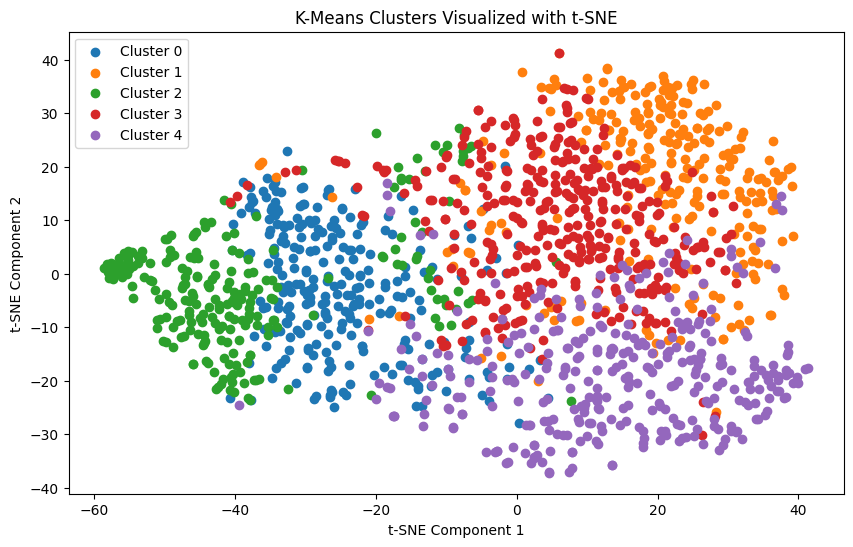

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
for cluster_id in range(num_clusters):
    indices = np.where(cluster_labels == cluster_id)
    plt.scatter(tsne_features[indices, 0], tsne_features[indices, 1], label=f"Cluster {cluster_id}")

plt.title("K-Means Clusters Visualized with t-SNE")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.show()